In [1]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    # Core pT4 properties
    'sim_pT4_matched',
    'pT4_pt',
    'pT4_isFake',
    'pT4_isDuplicate',
    'pT4_eta',
    'pT4_phi',
    # 'pT4_score',
    'pT4_matched_simIdx',
    'pT4_hitIdxs',
    'pT4_pixelRadius',
    'pT4_pixelRadiusError',
    'pT4_quadrupletRadius',
    'pT4_rPhiChiSquared',
    'pT4_rPhiChiSquaredInwards',
    'pT4_rzChiSquared',
    'pT4_layer_binary',
    'pT4_moduleType_binary',
    'pT4_pMatched'
]

# Hit-dependent branches
# suffixes = ['r', 'z', 'eta', 'phi', 'layer']
# branches_list += [f't3_hit_{i}_{suffix}' for i in [0, 1, 2, 3, 4, 5] for suffix in suffixes]

file_path = "pt4_addUncertToT4DNN_trainset_500event.root"
branches = load_root_file(file_path, branches_list)

In [2]:
#z_max = np.max([np.max(event) for event in branches[f't3_hit_3_z']])
#r_max = np.max([np.max(event) for event in branches[f't3_hit_3_r']])
eta_max = 2.5
phi_max = np.pi

#print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

In [3]:
def delta_phi(delta):
    delta = np.where(delta > np.pi, delta - 2*np.pi, delta)
    delta = np.where(delta < -np.pi, delta + 2*np.pi, delta)
    return delta

def symmetric_log10(x, offset=1.0, eps=1e-7):
    # Applies a log10 transform while preserving the sign.
    return np.sign(x) * np.log10(np.abs(x) + offset + eps)

def replace_negative(x, placeholder=1e-3):
    # Replace negative values with a small positive placeholder.
    return np.where(x < 0, placeholder, x)

n_events = branches['event']

# Concatenate the pT4 branches over all events
pT4_rPhiChiSquared = np.concatenate([branches['pT4_rPhiChiSquared'][evt] for evt in range(n_events)])
pT4_rPhiChiSquaredInwards = np.concatenate([branches['pT4_rPhiChiSquaredInwards'][evt] for evt in range(n_events)])
pT4_rzChiSquared = np.concatenate([branches['pT4_rzChiSquared'][evt] for evt in range(n_events)])
pT4_eta = np.abs(np.concatenate([branches['pT4_eta'][evt] for evt in range(n_events)]))
pT4_quad_rad = np.abs(np.concatenate([branches['pT4_quadrupletRadius'][evt] for evt in range(n_events)]))
pT4_pix_rad = np.abs(np.concatenate([branches['pT4_pixelRadius'][evt] for evt in range(n_events)]))
pT4_pixRadError = np.abs(np.concatenate([branches['pT4_pixelRadiusError'][evt] for evt in range(n_events)]))

# Build the features array using the helper functions
features = np.array([
    np.log10(pT4_rPhiChiSquared),              # pT4_rPhiChiSquared
    np.log10(pT4_quad_rad),
    np.log10(pT4_pix_rad),
    np.log10(pT4_pixRadError),
    np.log10(replace_negative(pT4_rzChiSquared)),          # pT4_rzChiSquared (replace negatives)
    np.abs(pT4_eta)/eta_max                            # pT4_eta (normalized)
])

eta_list = np.array([pT4_eta])

In [4]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# ------------------ Preprocessing ------------------
# Assumes that `features` and `branches` are defined beforehand.
# Stack features and filter out rows with NaN or Inf values.
input_features_numpy = np.stack(features, axis=-1)
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
pT4_isFake_filtered = 1 - (np.concatenate(branches['pT4_isFake']))[np.all(mask, axis=1)]

# Convert to PyTorch tensors.
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)
labels_tensor = torch.tensor(pT4_isFake_filtered, dtype=torch.float32).unsqueeze(1)

# ------------------ Device Setup ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------ Neural Network ------------------
class BinaryClassificationNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)  # Sigmoid activation for output between 0 and 1

# ------------------ Loss Function ------------------
class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedBinaryCrossEntropyLoss, self).__init__()

    def forward(self, outputs, targets, weights):
        eps = 1e-7
        loss = -(targets * torch.log(outputs + eps) + (1 - targets) * torch.log(1 - outputs + eps))
        weighted_loss = loss * weights
        return weighted_loss.mean()

# ------------------ Class Weight Calculation ------------------
def calculate_binary_class_weights(labels):
    total_samples = len(labels)
    count_positive = labels.sum().item()
    count_negative = total_samples - count_positive
    weight_positive = total_samples / (2 * count_positive) if count_positive > 0 else 1.0
    weight_negative = total_samples / (2 * count_negative) if count_negative > 0 else 1.0
    
    sample_weights = torch.zeros(total_samples)
    for i in range(total_samples):
        if labels[i] == 1:
            sample_weights[i] = weight_positive
        else:
            sample_weights[i] = weight_negative
    return sample_weights

# ------------------ Data Preparation ------------------
print(f"Initial dataset size: {len(labels_tensor)}")

# Remove any rows with NaN in the input features (if any remain).
nan_mask = torch.isnan(input_features_tensor).any(dim=1)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

# Print class distribution before downsampling.
num_fake = filtered_labels.sum().item()
num_real = len(filtered_labels) - num_fake
print(f"Class distribution before downsampling - Fake: {num_fake}, Real: {num_real}")

# Option to downsample the majority class.
downsample_classes = False  # Set to False to disable downsampling.
if downsample_classes:
    # Define downsampling ratios: here, fake (label 1) is downsampled to 20%, real (label 0) remains at 100%.
    downsample_ratios = {1: .5, 0: 1.0}
    indices_list = []

    # Process fake class (label 1).
    fake_mask = (filtered_labels.squeeze() == 1)
    fake_indices = torch.nonzero(fake_mask).squeeze()
    num_fake = fake_indices.numel()
    num_fake_to_sample = int(num_fake * downsample_ratios[1])
    if num_fake_to_sample < 1 and num_fake > 0:
        num_fake_to_sample = 1
    fake_indices_shuffled = fake_indices[torch.randperm(num_fake)]
    sampled_fake_indices = fake_indices_shuffled[:num_fake_to_sample]
    indices_list.append(sampled_fake_indices)

    # Process real class (label 0).
    real_mask = (filtered_labels.squeeze() == 0)
    real_indices = torch.nonzero(real_mask).squeeze()
    num_real = real_indices.numel()
    num_real_to_sample = int(num_real * downsample_ratios[0])
    if num_real_to_sample < 1 and num_real > 0:
        num_real_to_sample = 1
    real_indices_shuffled = real_indices[torch.randperm(num_real)]
    sampled_real_indices = real_indices_shuffled[:num_real_to_sample]
    indices_list.append(sampled_real_indices)

    # Combine indices from both classes.
    selected_indices = torch.cat(indices_list)
    filtered_inputs = filtered_inputs[selected_indices]
    filtered_labels = filtered_labels[selected_indices]

# Print class distribution after downsampling.
num_fake_after = filtered_labels.sum().item()
num_real_after = len(filtered_labels) - num_fake_after
print(f"Class distribution after downsampling - Fake: {num_fake_after}, Real: {num_real_after}")

# Calculate sample weights after downsampling.
sample_weights = calculate_binary_class_weights(filtered_labels)
filtered_weights = sample_weights

# Create the dataset.
dataset = TensorDataset(filtered_inputs, filtered_labels, filtered_weights)

# Split into train and test sets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders.
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# ------------------ Model, Loss, and Optimizer ------------------
input_dim = filtered_inputs.shape[1]
model = BinaryClassificationNeuralNetwork(input_dim).to(device)
loss_function = WeightedBinaryCrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_loss(loader):
    model.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets, weights in loader:
            inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets, weights)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

# ------------------ Training Loop ------------------
num_epochs = 200
train_loss_log = []
test_loss_log = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0

    for inputs, targets, weights in train_loader:
        inputs, targets, weights = inputs.to(device), targets.to(device), weights.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets, weights)
        epoch_loss += loss.item()
        num_batches += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss = epoch_loss / num_batches
    test_loss = evaluate_loss(test_loader)
    train_loss_log.append(train_loss)
    test_loss_log.append(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Using device: cuda
Initial dataset size: 1473353
Class distribution before downsampling - Fake: 1199110.0, Real: 274243.0
Class distribution after downsampling - Fake: 1199110.0, Real: 274243.0
Epoch [1/200], Train Loss: 0.1653, Test Loss: 0.1501
Epoch [2/200], Train Loss: 0.1442, Test Loss: 0.1418
Epoch [3/200], Train Loss: 0.1422, Test Loss: 0.1434
Epoch [4/200], Train Loss: 0.1412, Test Loss: 0.1411
Epoch [5/200], Train Loss: 0.1390, Test Loss: 0.1389
Epoch [6/200], Train Loss: 0.1345, Test Loss: 0.1307
Epoch [7/200], Train Loss: 0.1307, Test Loss: 0.1429
Epoch [8/200], Train Loss: 0.1290, Test Loss: 0.1274
Epoch [9/200], Train Loss: 0.1265, Test Loss: 0.1262
Epoch [10/200], Train Loss: 0.1261, Test Loss: 0.1228
Epoch [11/200], Train Loss: 0.1248, Test Loss: 0.1263
Epoch [12/200], Train Loss: 0.1245, Test Loss: 0.1233
Epoch [13/200], Train Loss: 0.1242, Test Loss: 0.1223
Epoch [14/200], Train Loss: 0.1241, Test Loss: 0.1221
Epoch [15/200], Train Loss: 0.1236, Test Loss: 0.1229
Epoch

In [5]:
torch.save(model.state_dict(), "model_pT4_uncertInT4DNN.pth")

In [6]:
from sklearn.metrics import accuracy_score

# Convert tensors to numpy for simplicity in permutation
input_features_np = input_features_tensor.numpy()
labels_np = labels_tensor.numpy()

def model_accuracy(features, labels, model):
    # Move the model to CPU for evaluation
    model.cpu()
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        # Ensure features and labels are on CPU
        inputs = features.to('cpu')
        labels = labels.to('cpu')
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Update threshold as necessary
        accuracy = (predicted == labels.squeeze()).float().mean().item()
    return accuracy

# Use the original input_features_tensor and labels_tensor directly
baseline_accuracy = model_accuracy(input_features_tensor, labels_tensor, model)
print(f"Baseline accuracy: {baseline_accuracy}")

# Initialize an array to store feature importances
feature_importances = np.zeros(input_features_tensor.shape[1])

# Permute each feature and calculate the drop in accuracy
for i in range(input_features_tensor.shape[1]):
    permuted_features = input_features_tensor.clone()
    permuted_features[:, i] = permuted_features[torch.randperm(permuted_features.size(0)), i]  # Permute feature

    permuted_accuracy = model_accuracy(permuted_features, labels_tensor, model)
    feature_importances[i] = baseline_accuracy - permuted_accuracy

# Ranking features by importance
important_features_indices = np.argsort(feature_importances)[::-1]  # Indices of features in descending importance
important_features_scores = np.sort(feature_importances)[::-1]  # Importance scores in descending order

print("Feature importances:")
for idx, score in zip(important_features_indices, important_features_scores):
    print(f"Feature {idx} importance: {score:.4f}")

Baseline accuracy: 0.9626973271369934
Feature importances:
Feature 2 importance: 0.4877
Feature 1 importance: 0.4777
Feature 4 importance: 0.1284
Feature 5 importance: 0.0678
Feature 0 importance: 0.0657
Feature 3 importance: 0.0427


/tmp/ipykernel_2184220/1646812576.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features, dtype=torch.float32).to('cpu')


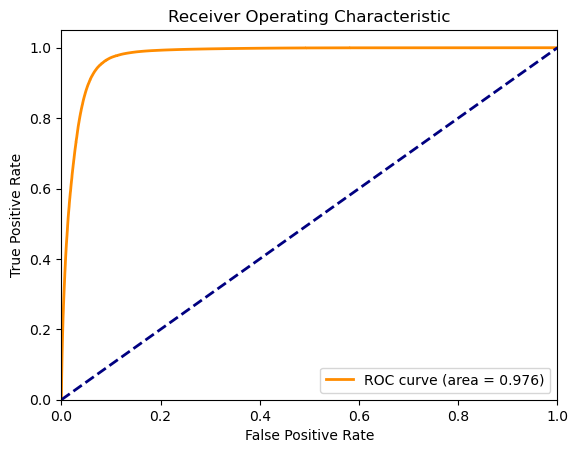

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model_outputs(features, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(features, dtype=torch.float32).to('cpu')
        outputs = model(inputs).squeeze().cpu().numpy()
    return outputs

# Calculate model outputs
probabilities = model_outputs(filtered_inputs, model)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(filtered_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)

ALPAKA_STATIC_ACC_MEM_GLOBAL const float bias_layer1[32] = {
-0.2172626f, 1.0924847f, -0.7741776f, 1.2540965f, -0.4305124f, -0.3080544f, 0.4992006f, -0.6960329f, -2.6452785f, -2.3823905f, -0.0581807f, -0.2138740f, 0.2358842f, -0.2925083f, 0.0184358f, 0.8808457f, -0.7788085f, -0.7563241f, 0.6299098f, -0.8704662f, -1.2808937f, -3.0916419f, -0.3292235f, -0.1208334f, 1.0766973f, 0.3868034f, -0.1631837f, 1.1513985f, 0.1640509f, 0.4137579f, 0.6032500f, -1.1044726f };

ALPAKA_STATIC_ACC_MEM_GLOBAL const float wgtT_layer1[6][32] = {
{ -0.0064190f, -0.0107431f, 0.0096785f, -0.4128326f, -0.0138789f, 0.1332161f, -0.1875351f, 0.9645722f, 0.0212512f, 1.5278677f, 0.0397647f, -0.9662701f, -0.1137345f, -0.2172248f, -0.0472349f, 0.7544203f, -0.1122693f, -0.0930058f, -0.0173923f, 0.0650332f, 0.0205304f, 0.0307580f, 0.0303145f, -0.0634593f, -0.0775036f, -0.4157204f, 0.1568288f, -0.0438685f, 0.0287328f, -0.0746232f, -0.0192777f, -0.2287125f },
{ -0.3080060f, -1.4935918f, -1.2885628f, -0.2928801f, -1.36211

In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# ------------------ Preprocessing ------------------
# Assumes that `features` and `branches` are defined beforehand.
# Stack features and filter out rows with NaN or Inf values.
input_features_numpy = np.stack(features, axis=-1)
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
pT4_isFake_filtered = 1 - (np.concatenate(branches['pT4_isFake']))[np.all(mask, axis=1)]

# Convert to PyTorch tensors.
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)
labels_tensor = torch.tensor(pT4_isFake_filtered, dtype=torch.float32).unsqueeze(1)

# ------------------ Device Setup ------------------
device = torch.device("cpu")
print(f"Using device: {device}")

# ------------------ Neural Network ------------------
class BinaryClassificationNeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)  # Sigmoid activation for output between 0 and 1

Using device: cpu


In [14]:
nan_mask = torch.isnan(input_features_tensor).any(dim=1)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]
input_dim = filtered_inputs.shape[1]
model =BinaryClassificationNeuralNetwork(input_dim).to(device)
model.load_state_dict(torch.load("model_pT4_uncertInT4DNN.pth", map_location=torch.device('cpu')))

/tmp/ipykernel_2184220/1817525576.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_pT4_uncertInT4DNN.pth", map_location=torch.devi

<All keys matched successfully>

In [15]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to('cpu')

# Make predictions
with torch.no_grad():
    input_features_tensor = input_features_tensor.to('cpu')
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()

full_tracks = (np.concatenate(branches['pT4_isFake']) == 0)*(np.concatenate(branches['pT4_pMatched'])>0.95)

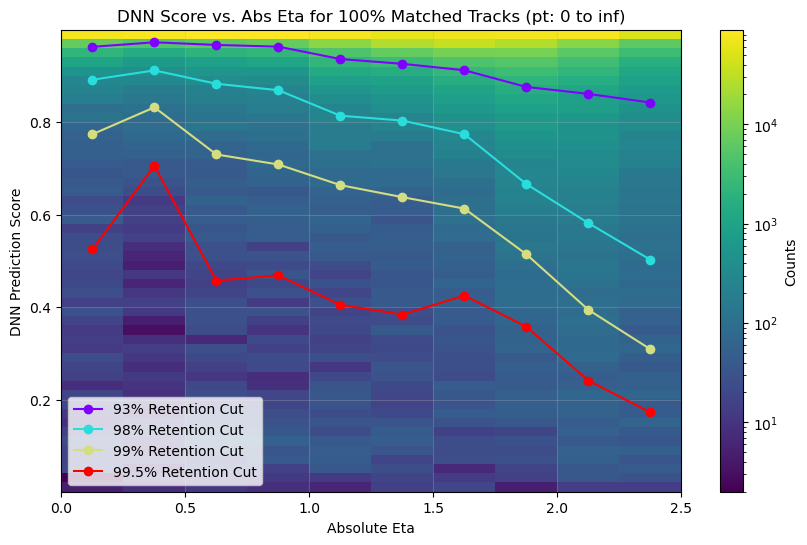


pt: 0 to inf
93% Retention Cut: {0.963, 0.9728, 0.9671, 0.9634, 0.9366, 0.9263, 0.9123, 0.8762, 0.8612, 0.8425} Mean: 0.9221
98% Retention Cut: {0.8919, 0.9121, 0.8831, 0.8692, 0.814, 0.8035, 0.7741, 0.6662, 0.5819, 0.5026} Mean: 0.7698
99% Retention Cut: {0.774, 0.8322, 0.7303, 0.7086, 0.6639, 0.638, 0.6132, 0.5144, 0.3944, 0.3091} Mean: 0.6178
99.5% Retention Cut: {0.5248, 0.7056, 0.4575, 0.469, 0.4051, 0.3841, 0.4253, 0.3577, 0.2414, 0.1725} Mean: 0.4143


In [16]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['pT4_pt']) > pt_min) & 
                         (np.concatenate(branches['pT4_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['pT4_pt']) > pt_min) & 
                                    (np.concatenate(branches['pT4_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = [93, 98, 99, 99.5]
pt_bins = [0, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)

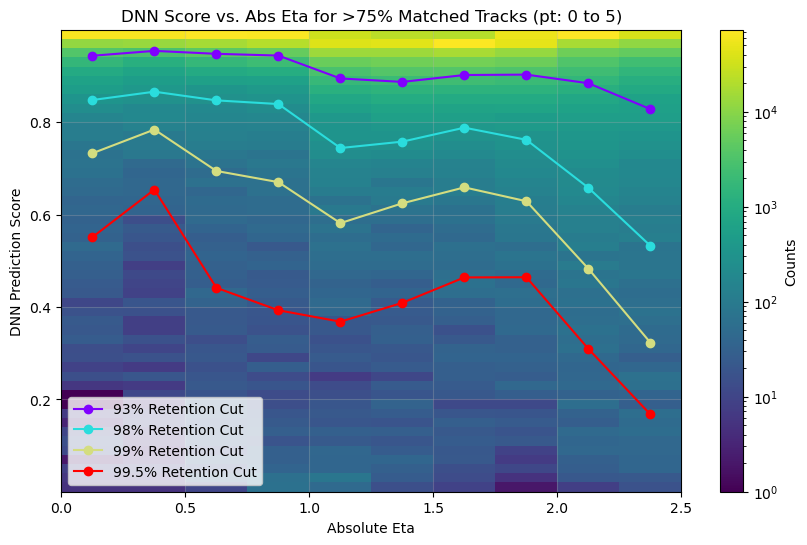


pt: 0 to 5
93% Retention Cut: {0.9437, 0.9542, 0.9478, 0.944, 0.8945, 0.887, 0.902, 0.9028, 0.8841, 0.8281} Mean: 0.9088
98% Retention Cut: {0.8478, 0.8659, 0.8471, 0.8391, 0.7439, 0.7578, 0.788, 0.7617, 0.6579, 0.5324} Mean: 0.7642
99% Retention Cut: {0.7326, 0.7839, 0.6943, 0.6701, 0.5814, 0.6243, 0.6588, 0.6288, 0.4827, 0.3228} Mean: 0.618
99.5% Retention Cut: {0.551, 0.654, 0.4415, 0.3929, 0.3682, 0.409, 0.464, 0.4643, 0.3093, 0.1675} Mean: 0.4222


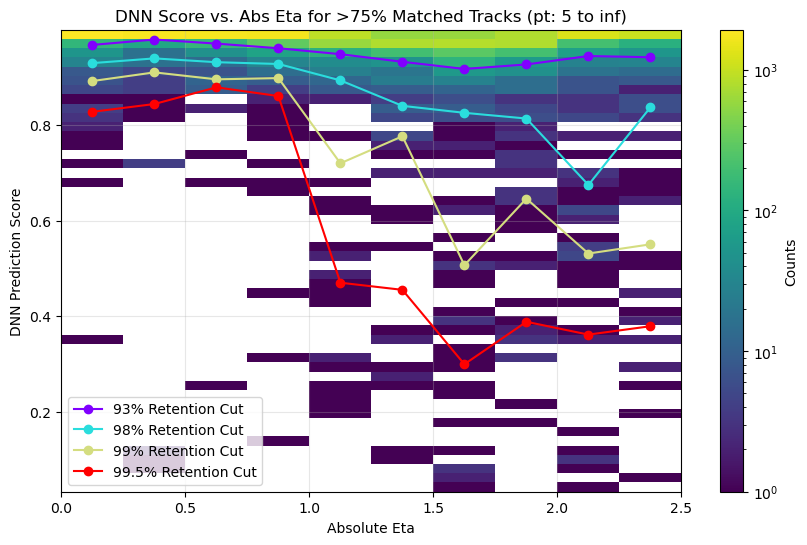


pt: 5 to inf
93% Retention Cut: {0.9681, 0.9794, 0.9709, 0.9612, 0.9488, 0.9328, 0.9178, 0.9272, 0.9449, 0.9423} Mean: 0.9493
98% Retention Cut: {0.9301, 0.9399, 0.932, 0.9282, 0.8939, 0.8406, 0.826, 0.8141, 0.6751, 0.8375} Mean: 0.8617
99% Retention Cut: {0.8925, 0.9106, 0.8961, 0.8987, 0.7204, 0.7769, 0.5071, 0.6464, 0.5315, 0.5508} Mean: 0.7331
99.5% Retention Cut: {0.8282, 0.8444, 0.8794, 0.8611, 0.4705, 0.4555, 0.2998, 0.3887, 0.3618, 0.3794} Mean: 0.5769


In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin(pt_min, pt_max, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Calculate and plot cut values for specified percentiles in a given pt bin
    
    Parameters:
    -----------
    pt_min : float
        Minimum pt value for the bin
    pt_max : float
        Maximum pt value for the bin
    percentiles : list
        List of percentiles to calculate (e.g., [92.5, 96.7, 99])
    eta_bin_edges : array
        Edges of the eta bins
    eta_list : list
        List of eta values
    predictions : array
        Array of DNN predictions
    full_tracks : array
        Boolean array for track selection
    branches : dict
        Dictionary containing branch data
    """
    # Filter data based on pt bin
    abs_eta = eta_list[0][full_tracks & (np.concatenate(branches['pT4_pt']) > pt_min) & 
                         (np.concatenate(branches['pT4_pt']) <= pt_max)]
    predictions_filtered = predictions[full_tracks & (np.concatenate(branches['pT4_pt']) > pt_min) & 
                                    (np.concatenate(branches['pT4_pt']) <= pt_max)]
    
    # Dictionary to store cut values for different percentiles
    cut_values = {p: [] for p in percentiles}

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        for percentile in percentiles:
            cut_value = np.percentile(bin_predictions, 100 - percentile)  # Convert retention to percentile
            cut_values[percentile].append(cut_value)

    # Plot 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for >75% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values with different colors
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))  # Generate distinct colors
    
    for percentile, color in zip(percentiles, colors):
        plt.plot(cut_x, cut_values[percentile], '-', color=color, marker='o', 
                label=f'{percentile}% Retention Cut')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print the cut values
    print(f"\npt: {pt_min} to {pt_max}")
    for percentile in percentiles:
        values = cut_values[percentile]
        print(f"{percentile}% Retention Cut:", 
              '{' + ', '.join(str(x) for x in np.round(values, 4)) + '}',
              "Mean:", np.round(np.mean(values), 4))

# Example usage:
def analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches):
    """
    Analyze and plot for multiple pt bins and percentiles
    
    Parameters:
    -----------
    pt_bins : list
        List of pt bin edges
    percentiles : list
        List of percentiles to calculate
    Other parameters same as plot_for_pt_bin function
    """
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges, 
                       eta_list, predictions, full_tracks, branches)

# Example call:
percentiles = [93, 98, 99, 99.5]
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)
analyze_pt_bins(pt_bins, percentiles, eta_bin_edges, eta_list, predictions, full_tracks, branches)